In [1]:
from pynq import Overlay, allocate
import matplotlib.pyplot as plt
import numpy as np

# Load bitstream into PL.
overlay = Overlay("design_1_wrapper.bit", download=True)
dma = overlay.axi_dma_0

print("Done!")

Done!


In [2]:
# Create a test signal.
fft_length = 4096
fs = 4096

x = np.arange(fft_length) / fs
y = np.zeros(fft_length, dtype = np.int16)
y[fft_length // 2 - 200: fft_length // 2 + 200] = 1000

In [3]:
# Allocate a space for DMA transfer.

dma_tx_buffer = allocate(shape = (fft_length,), dtype = np.uint32)
dma_rx_buffer = allocate(shape = (fft_length,), dtype = np.float32)

print(f'DMA TX Buffer Address:{hex(dma_tx_buffer.physical_address)}')
print(f'DMA RX Buffer Address:{hex(dma_rx_buffer.physical_address)}')

DMA TX Buffer Address:0x1684c000
DMA RX Buffer Address:0x16850000


In [4]:
# Pack data into the form that FFT IP accept.
real_part = np.uint16(y)
imag_part = np.zeros(shape = (fft_length,), dtype = np.uint16)

print("Real Part:", real_part)
print("Imag Part:", imag_part)

for i in range(fft_length):
    r = np.uint16(real_part[i])
    j = np.uint16(imag_part[i])
    dma_tx_buffer[i] = (j << 16) | r

Real Part: [0 0 0 ... 0 0 0]
Imag Part: [0 0 0 ... 0 0 0]


In [5]:
# Define hardware FFT and software FFT functions.

xb_hardware = np.fft.fftfreq(fft_length, d = 1 / fs)
yb_hardware = np.zeros(fft_length, dtype=np.float32)

def hardware_fft():
    dma.recvchannel.transfer(dma_rx_buffer)
    dma.sendchannel.transfer(dma_tx_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    yb_hardware[:] = dma_rx_buffer

xb_software = np.fft.fftfreq(fft_length, d = 1 / fs)
yb_software = np.zeros(fft_length, dtype=np.float32)

def software_fft():
    yb_software[:] = np.abs(np.fft.fft(y))


In [6]:
%%timeit
hardware_fft()
# Test hardware FFT execution time

841 µs ± 5.77 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%%timeit
software_fft()
# Test software FFT execution time

2.39 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


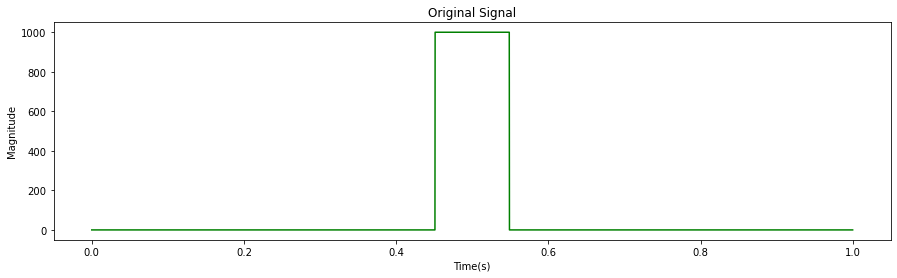

In [8]:
# Plot original test signal
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(x, y, color='g')
axs.set_title("Original Signal")
axs.set_ylabel("Magnitude")
axs.set_xlabel("Time(s)")

plt.show()

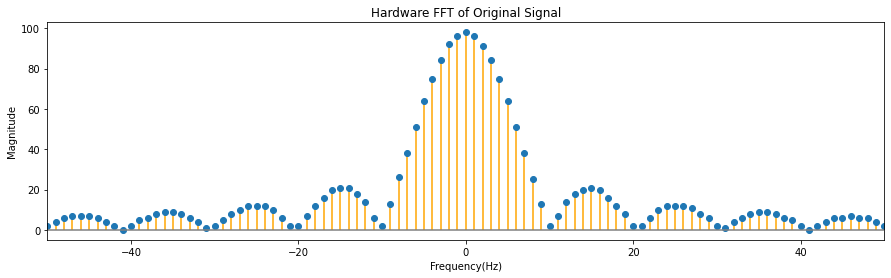

In [9]:
# Plot result of hardware FFT
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

axs.stem(np.fft.fftshift(xb_hardware), np.fft.fftshift(yb_hardware),
         linefmt='orange', markerfmt='o', basefmt='gray',
         label='Hardware FFT')

axs.set_title("Hardware FFT of Original Signal")
axs.set_ylabel("Magnitude")
axs.set_xlabel("Frequency(Hz)")
axs.set_xlim(-50, 50)
plt.show()

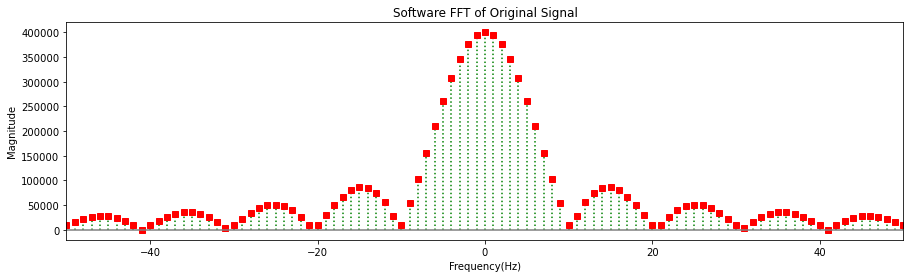

In [10]:
# Result of software FFT
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

axs.stem(xb_software, yb_software,
         linefmt='g:', markerfmt='rs', basefmt='gray',
         label='Software FFT')

axs.set_title("Software FFT of Original Signal")
axs.set_ylabel("Magnitude")
axs.set_xlabel("Frequency(Hz)")
axs.set_xlim(-50, 50)

plt.show()

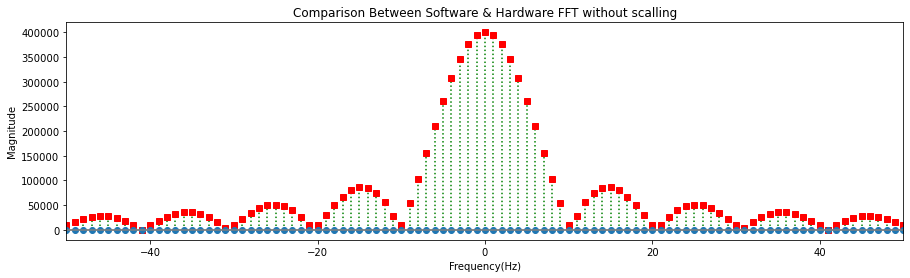

In [11]:
# Comparison between software and hardware FFT without scalling
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

axs.stem(xb_software, yb_software,
         linefmt='g:', markerfmt='rs', basefmt='gray',
         label='Software FFT')

axs.stem(xb_hardware, yb_hardware,
         linefmt='orange', markerfmt='o', basefmt='gray',
         label='Hardware FFT')

axs.set_title("Comparison Between Software & Hardware FFT without scalling")
axs.set_ylabel("Magnitude")
axs.set_xlabel("Frequency(Hz)")
axs.set_xlim(-50, 50)

plt.show()

Hardware FFT: Max(98.0), Min(0.0)
Software FFT: Max(400000.0), Min(0.0)


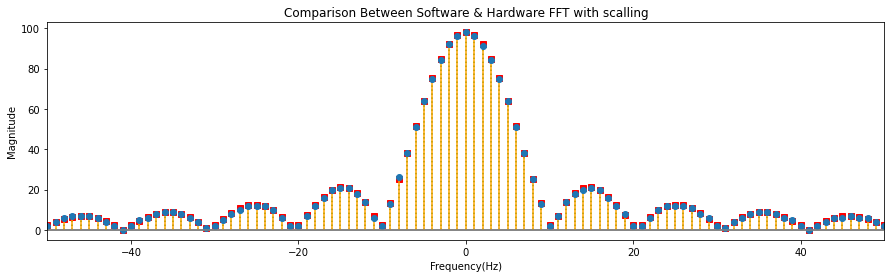

In [12]:
# Comparison between software and hardware FFT "with" scalling

plt.close()

print(f'Hardware FFT: Max({max(yb_hardware)}), Min({min(yb_hardware)})')
print(f'Software FFT: Max({max(yb_software)}), Min({min(yb_hardware)})')

yb_software = yb_software / max(yb_software) * max(yb_hardware)

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

axs.stem(xb_software, yb_software,
         linefmt='g:', markerfmt='rs', basefmt='gray',
         label='Software FFT')

axs.stem(xb_hardware, yb_hardware,
         linefmt='orange', markerfmt='o', basefmt='gray',
         label='Hardware FFT')

axs.set_title("Comparison Between Software & Hardware FFT with scalling")
axs.set_ylabel("Magnitude")
axs.set_xlabel("Frequency(Hz)")
axs.set_xlim(-50, 50)

plt.show()